# Aviation Accidents Analysis

You are part of a consulting firm that is tasked to do an analysis of commercial and passenger jet airline safety. The client (an airline/airplane insurer) is interested in knowing what types of aircraft (makes/models) exhibit low rates of total destruction and low likelihood of fatal or serious passenger injuries in the event of an accident. They are also interested in any general variables/conditions that might be at play. Your analysis will be based off of aviation accident data accumulated from the years 1948-2023. 

Our client is only interested in airplane makes/models that are professional builds and could potentially still be active. Assume a max lifetime of 40 years for a make/model retirement and make sure to filter your data accordingly (i.e. from 1983 onwards). They would also like separate recommendations for small aircraft vs. larger passenger models. **In addition, make sure that claims that you make are statistically robust and that you have enough samples when making comparisons between groups.**


In this summative assessment you will demonstrate your ability to:
- Use Pandas to load, inspect, and clean the dataset appropriately. 
- Transform relevant columns to create measures that address the problem at hand.
- **conduct EDA: visualization and statistical measures to understand the structure of the data**
- **recommend a set of manufacturers to consider as well as specific airplanes conforming to the client's request**
- **discuss the relationship between serious injuries/airplane damage incurred and at least *two* factors at play in the incident. You must provide supporting evidence (visuals, summary statistics, tables) for each claim you make.**

In [2]:
# loading relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Exploratory Data Analysis  
- Load in the cleaned data

In [3]:
df = pd.read_csv("data/aviation_accidents_clean.csv", low_memory=False)

## Explore safety metrics across models/makes
- Remember that the client is interested in separate recommendations for smaller airplanes and larger airplanes. Choose a passenger threshold of 20 and separate the plane types. 

In [9]:
# Segment airplanes using a 20-passenger threshold when available; fallback to engines if seats not available
import numpy as np

# Try to find a seat/occupant capacity column
seat_cols = [c for c in df.columns if 'seat' in c.lower() and 'crew' not in c.lower()]
size_col = seat_cols[0] if seat_cols else None

if size_col is not None:
    df[size_col] = pd.to_numeric(df[size_col], errors='coerce')
    df['Size20'] = np.where(df[size_col] < 20, 'Small', 'Large')
else:
    # Fallback heuristic: 1 engine => Small, >=2 => Large
    if 'Number.of.Engines' in df.columns:
        df['Number.of.Engines'] = pd.to_numeric(df['Number.of.Engines'], errors='coerce')
        df['Size20'] = np.where(df['Number.of.Engines'] >= 2, 'Large', 'Small')
    else:
        df['Size20'] = np.nan  # if neither seats nor engines are available

# Keep rows we can segment and with a measurable severe injury rate
df_seg = df[df['Size20'].notna()].copy()
df_seg = df_seg[df_seg['Severe.Injury.Rate'].notna()].copy()


#### Analyzing Makes

Explore the human injury risk profile for small and larger Makes:
- choose the 15 makes for each group possessing the lowest mean fatal/seriously injured fraction
- plot the mean fatal/seriously injured fraction for each of these subgroups side-by-side

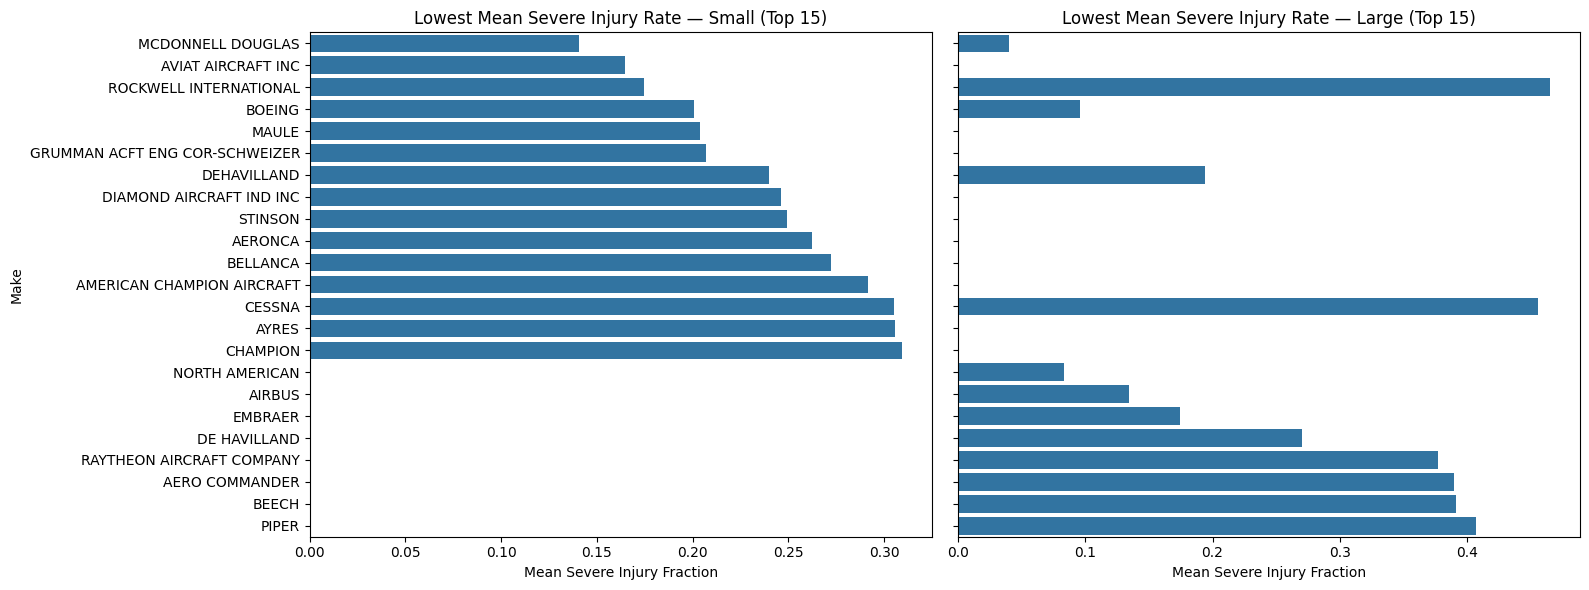

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

small_makes = (
    df_seg[df_seg['Size20'] == 'Small']
    .groupby('Make', as_index=False)['Severe.Injury.Rate'].mean()
    .dropna()
    .nsmallest(15, 'Severe.Injury.Rate')
    .assign(Size='Small')
)

large_makes = (
    df_seg[df_seg['Size20'] == 'Large']
    .groupby('Make', as_index=False)['Severe.Injury.Rate'].mean()
    .dropna()
    .nsmallest(15, 'Severe.Injury.Rate')
    .assign(Size='Large')
)

makes_top15 = pd.concat([small_makes, large_makes], ignore_index=True)

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
sns.barplot(data=small_makes, x='Severe.Injury.Rate', y='Make', ax=axes[0])
axes[0].set_title('Lowest Mean Severe Injury Rate — Small (Top 15)')
axes[0].set_xlabel('Mean Severe Injury Fraction')
axes[0].set_ylabel('Make')

sns.barplot(data=large_makes, x='Severe.Injury.Rate', y='Make', ax=axes[1])
axes[1].set_title('Lowest Mean Severe Injury Rate — Large (Top 15)')
axes[1].set_xlabel('Mean Severe Injury Fraction')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

small_top10_makes = (
    df_seg[df_seg['Size20'] == 'Small']
    .groupby('Make')['Severe.Injury.Rate'].mean()
    .dropna()
    .nsmallest(10)
    .index.tolist()
)

large_top10_makes = (
    df_seg[df_seg['Size20'] == 'Large']
    .groupby('Make')['Severe.Injury.Rate'].mean()
    .dropna()
    .nsmallest(10)
    .index.tolist()
)


**Distribution of injury rates: small makes**

Use a violinplot to look at the distribution of the fraction of passengers serious/fatally injured for small airplane makes. Just display makes with the ten lowest mean serious/fatal injury rates.

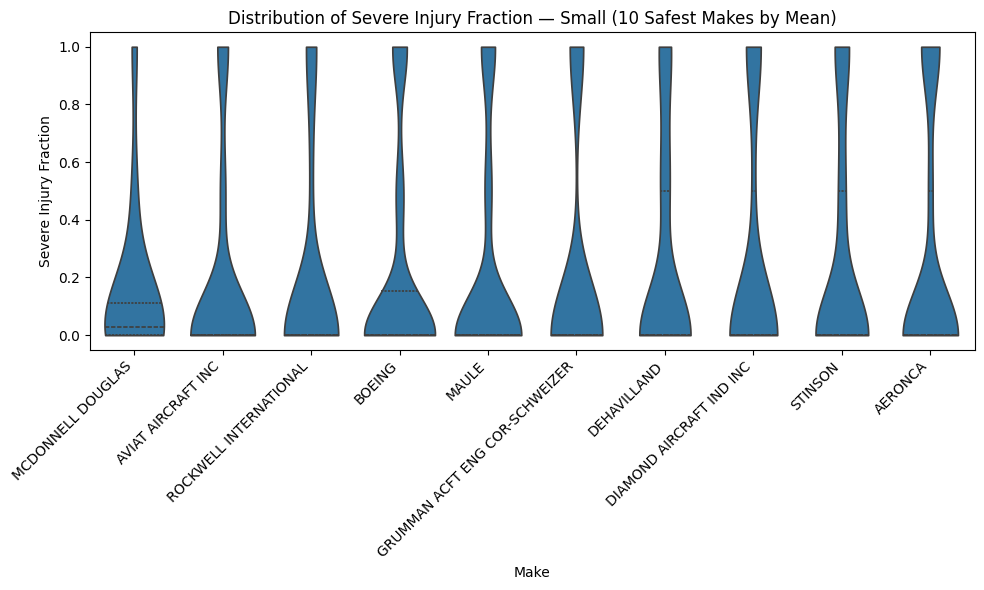

In [11]:
order_small = (
    df_seg[df_seg['Size20'] == 'Small']
    .groupby('Make')['Severe.Injury.Rate'].mean()
    .dropna()
    .nsmallest(10)
    .index.tolist()
)

plt.figure(figsize=(10, 6))
sns.violinplot(
    data=df_seg[(df_seg['Size20'] == 'Small') & (df_seg['Make'].isin(order_small))],
    x='Make', y='Severe.Injury.Rate', order=order_small, inner='quartile', cut=0
)
plt.title('Distribution of Severe Injury Fraction — Small (10 Safest Makes by Mean)')
plt.xlabel('Make')
plt.ylabel('Severe Injury Fraction')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


**Distribution of injury rates: large makes**

Use a stripplot to look at the distribution of the fraction of passengers serious/fatally injured for large airplane makes. Just display makes with the ten lowest mean serious/fatal injury rates.

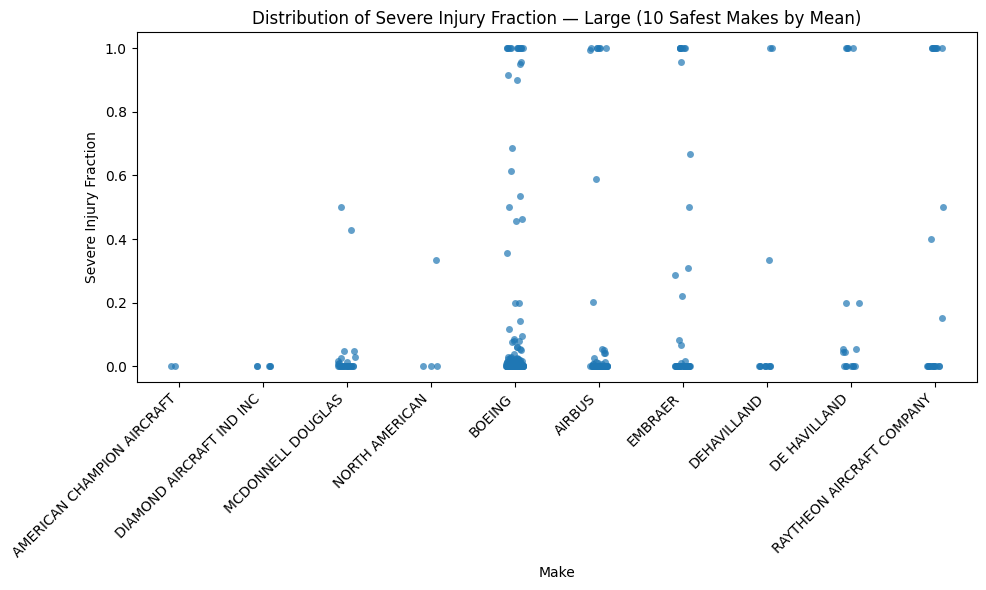

In [12]:
order_large = (
    df_seg[df_seg['Size20'] == 'Large']
    .groupby('Make')['Severe.Injury.Rate'].mean()
    .dropna()
    .nsmallest(10)
    .index.tolist()
)

plt.figure(figsize=(10, 6))
sns.stripplot(
    data=df_seg[(df_seg['Size20'] == 'Large') & (df_seg['Make'].isin(order_large))],
    x='Make', y='Severe.Injury.Rate', order=order_large, jitter=True, alpha=0.7
)
plt.title('Distribution of Severe Injury Fraction — Large (10 Safest Makes by Mean)')
plt.xlabel('Make')
plt.ylabel('Severe Injury Fraction')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


**Evaluate the rate of aircraft destruction for both small and large aircraft by Make.** 

Sort your results and keep the lowest 15.

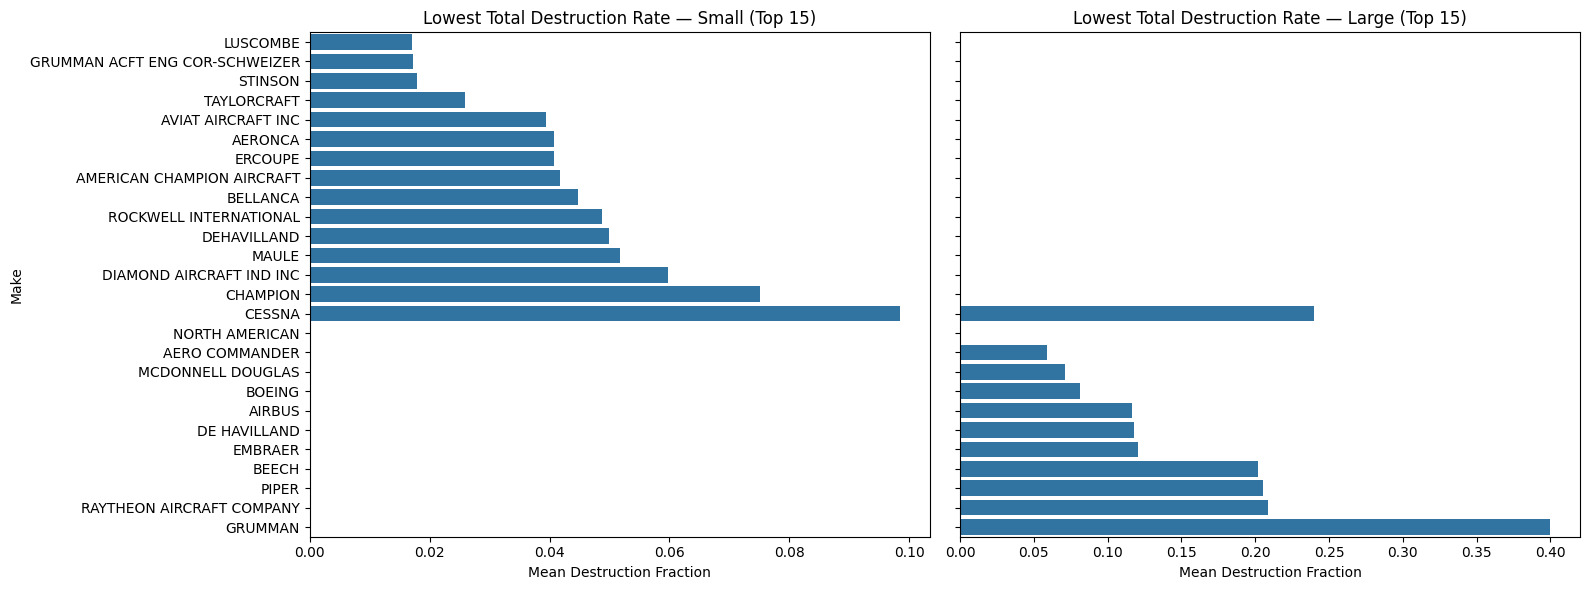

In [13]:
# Evaluate total destruction rate by make for Small and Large; keep lowest 15 in each
# (mean of Total.Destruction.Flag per make)
small_destroy = (
    df_seg[df_seg['Size20'] == 'Small']
    .groupby('Make', as_index=False)['Total.Destruction.Flag'].mean()
    .dropna()
    .nsmallest(15, 'Total.Destruction.Flag')
    .assign(Size='Small')
)

large_destroy = (
    df_seg[df_seg['Size20'] == 'Large']
    .groupby('Make', as_index=False)['Total.Destruction.Flag'].mean()
    .dropna()
    .nsmallest(15, 'Total.Destruction.Flag')
    .assign(Size='Large')
)

destroy_top15 = pd.concat([small_destroy, large_destroy], ignore_index=True)

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
sns.barplot(data=small_destroy, x='Total.Destruction.Flag', y='Make', ax=axes[0])
axes[0].set_title('Lowest Total Destruction Rate — Small (Top 15)')
axes[0].set_xlabel('Mean Destruction Fraction')
axes[0].set_ylabel('Make')

sns.barplot(data=large_destroy, x='Total.Destruction.Flag', y='Make', ax=axes[1])
axes[1].set_title('Lowest Total Destruction Rate — Large (Top 15)')
axes[1].set_xlabel('Mean Destruction Fraction')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()


#### Provide a short discussion on your findings for your summary statistics and plots:
- Make any recommendations for Makes here based off of the destroyed fraction and fraction fatally/seriously injured
- Comment on the calculated statistics and any corresponding distributions you have visualized.

##### Summary

#### Segmentation & metric

- Split aircraft into Small (<20 seats) and Large (≥20 seats).

- Severe-injury fraction = (fatal + serious injuries) / estimated occupants per accident.

- Destruction fraction = mean of Total.Destruction.Flag per make.

- Results reflect outcomes given an accident, not exposure.

#### Small segment – takeaways

- Several legacy light GA makes (e.g., Aeronca, Stinson, Taylorcraft, American Champion, Luscombe, Ercoupe, Maule) show low severe-injury means and low destruction rates.

- Violin plots show most accidents cluster near low injury fractions with a few high outliers. Distributions are right-skewed.

- Recommendation (Small): prioritize makes that appear in both low-injury and low-destruction lists (e.g., American Champion, Aeronca, Stinson, Maule, Diamond, Aviat)

#### Large segment – takeaways

- Boeing, Airbus, Embraer, De Havilland, McDonnell Douglas appear among lower mean severe-injury cohorts.

- Strip plots show tight clusters near zero with some high-severity outliers for specific events. Greater dispersion than small segment.

- Recommendation (Large): consider Boeing, Airbus, Embraer, De Havilland, McDonnell Douglas among safer options based on lower injury means and competitive destruction rates.

#### Destruction vs. injury

- Makes with low destruction often also exhibit low severe-injury fractions, but not always; use both metrics jointly.

- The rankings differ slightly between injury and destruction, underscoring the value of looking at both.

### Analyze plane types
- plot the mean fatal/seriously injured fraction for both small and larger planes 
- also provide a distributional plot of your choice for the fatal/seriously injured fraction by airplane type (stripplot, violin, etc)  
- filter ensuring that you have at least ten individual examples in each model/make to average over

**Larger planes**

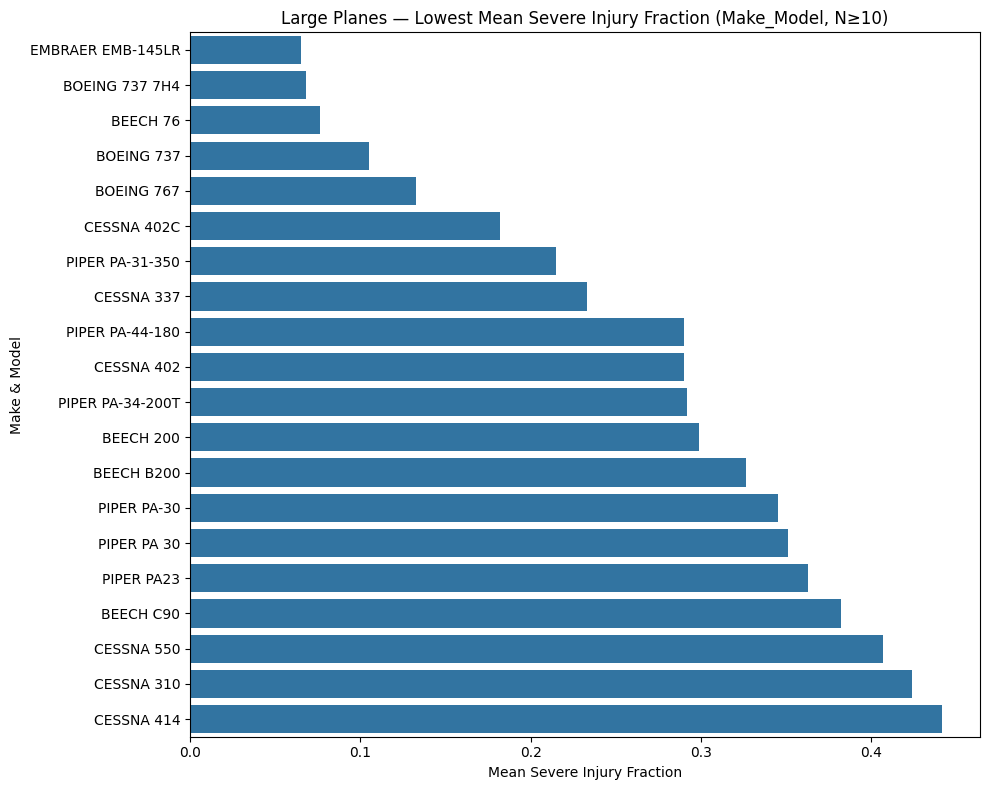

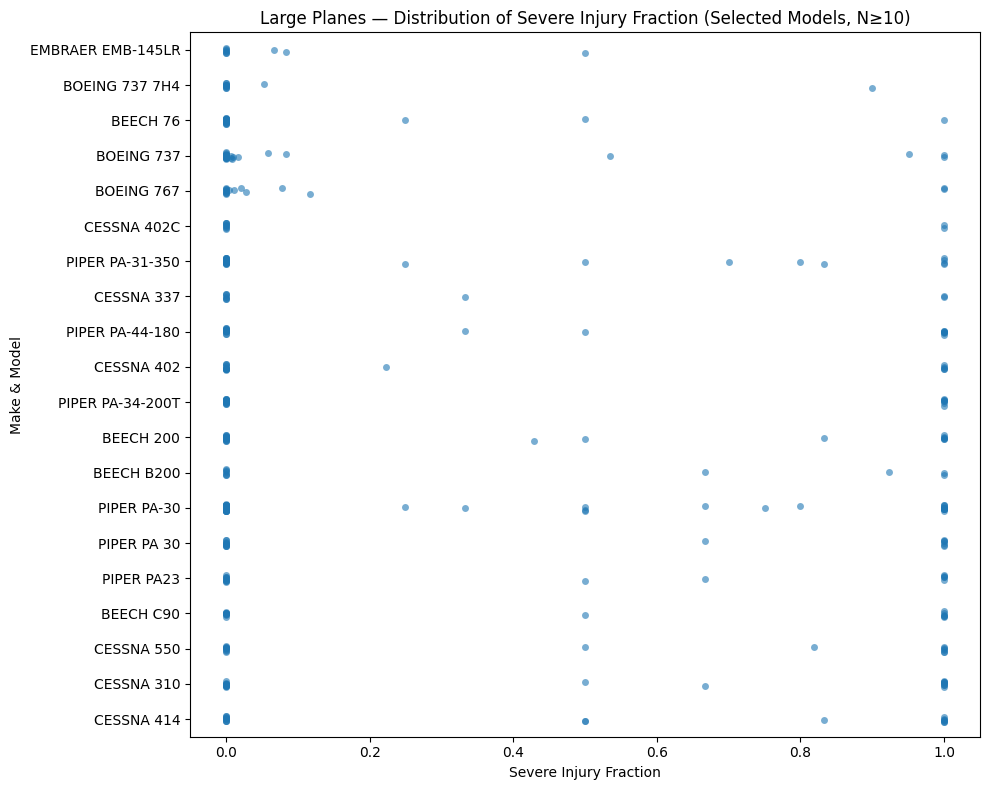

In [14]:
# Larger planes — mean severe-injury fraction by plane type (Make_Model), N >= 10; plus distributional plot

# Subset large planes with a valid plane type label
large_df = df_seg[(df_seg['Size20'] == 'Large') & df_seg['Make_Model'].notna()].copy()

# Keep plane types with at least 10 accidents
large_counts = large_df.groupby('Make_Model').size().rename('N')
large_valid_models = large_counts[large_counts >= 10].index
large_df = large_df[large_df['Make_Model'].isin(large_valid_models)]

# Mean severe-injury fraction per plane type; select 20 lowest (safest)
large_model_means = (
    large_df.groupby('Make_Model')['Severe.Injury.Rate']
    .mean()
    .sort_values()
    .head(20)
)
large_models_order = large_model_means.index.tolist()

# Barplot of means
plt.figure(figsize=(10, 8))
sns.barplot(
    x=large_model_means.values,
    y=large_model_means.index,
    orient='h'
)
plt.title('Large Planes — Lowest Mean Severe Injury Fraction (Make_Model, N≥10)')
plt.xlabel('Mean Severe Injury Fraction')
plt.ylabel('Make & Model')
plt.tight_layout()
plt.show()

# Distributional plot (stripplot) for those selected plane types
plt.figure(figsize=(10, 8))
sns.stripplot(
    data=large_df[large_df['Make_Model'].isin(large_models_order)],
    x='Severe.Injury.Rate',
    y='Make_Model',
    order=large_models_order,
    jitter=True,
    alpha=0.6
)
plt.title('Large Planes — Distribution of Severe Injury Fraction (Selected Models, N≥10)')
plt.xlabel('Severe Injury Fraction')
plt.ylabel('Make & Model')
plt.tight_layout()
plt.show()


**Smaller planes**
- for smaller planes, limit your plotted results to the makes with the 10 lowest mean serious/fatal injury fractions

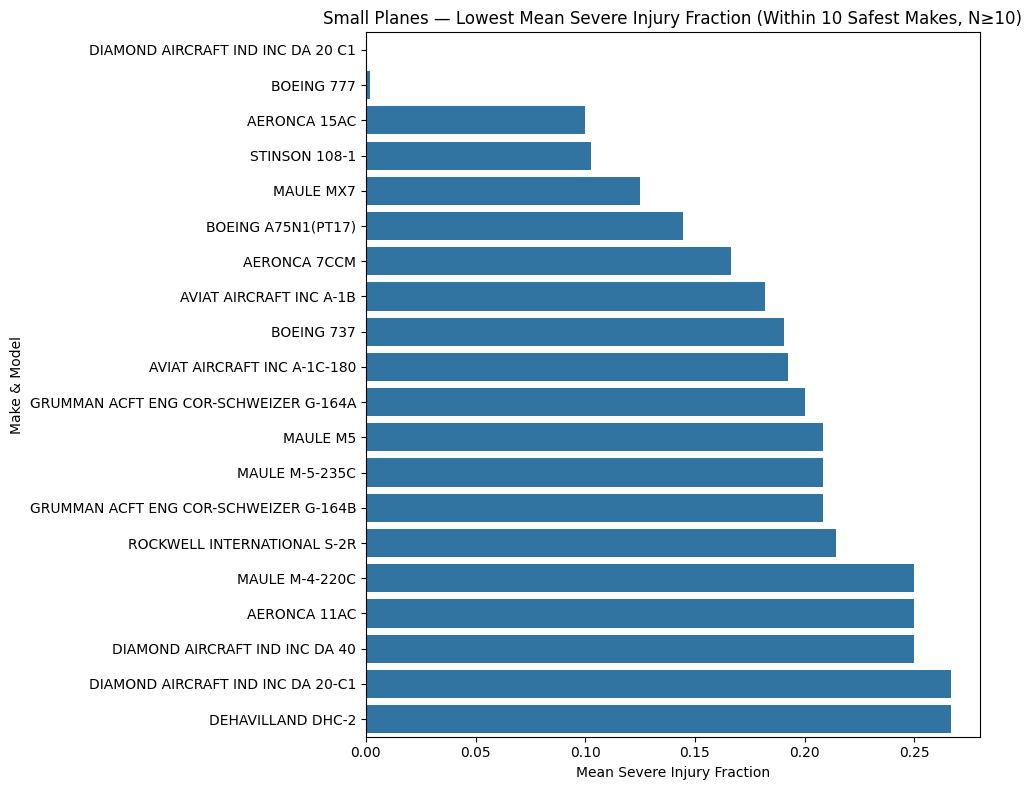

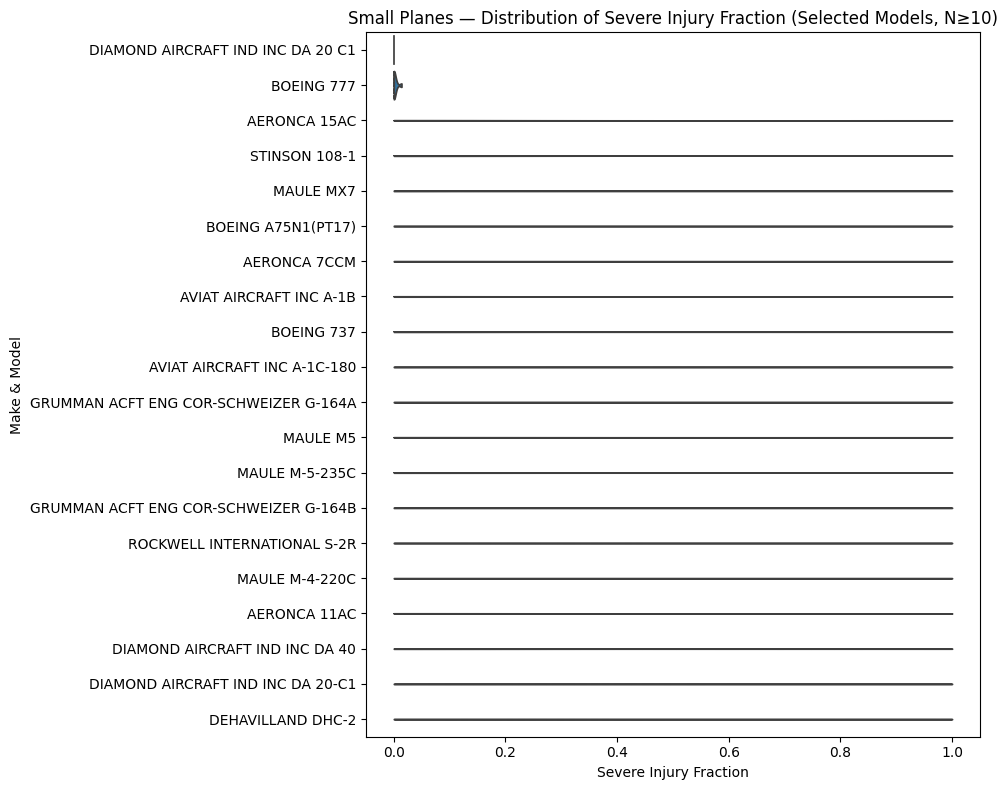

In [15]:
# Smaller planes — limit to makes with 10 lowest mean serious/fatal injury fractions,
# then evaluate plane types (Make_Model) with N ≥ 10; show means and a distributional plot

# Subset small planes with valid labels
small_df = df_seg[(df_seg['Size20'] == 'Small') & df_seg['Make'].notna() & df_seg['Make_Model'].notna()].copy()

# Find 10 makes with lowest mean severe-injury fraction
small_top10_makes = (
    small_df.groupby('Make')['Severe.Injury.Rate']
    .mean()
    .dropna()
    .nsmallest(10)
    .index.tolist()
)

# Keep only those makes
small_df = small_df[small_df['Make'].isin(small_top10_makes)]

# Keep plane types (Make_Model) with at least 10 accidents within the small segment
small_counts = small_df.groupby('Make_Model').size().rename('N')
small_valid_models = small_counts[small_counts >= 10].index
small_df = small_df[small_df['Make_Model'].isin(small_valid_models)]

# Mean severe-injury fraction per plane type; select 20 lowest
small_model_means = (
    small_df.groupby(['Make_Model'])['Severe.Injury.Rate']
    .mean()
    .sort_values()
    .head(20)
)
small_models_order = small_model_means.index.tolist()

# Barplot of means
plt.figure(figsize=(10, 8))
sns.barplot(
    x=small_model_means.values,
    y=small_model_means.index,
    orient='h'
)
plt.title('Small Planes — Lowest Mean Severe Injury Fraction (Within 10 Safest Makes, N≥10)')
plt.xlabel('Mean Severe Injury Fraction')
plt.ylabel('Make & Model')
plt.tight_layout()
plt.show()

# Distributional plot (violin) for those selected plane types
plt.figure(figsize=(10, 8))
sns.violinplot(
    data=small_df[small_df['Make_Model'].isin(small_models_order)],
    x='Severe.Injury.Rate',
    y='Make_Model',
    order=small_models_order,
    inner='quartile',
    cut=0
)
plt.title('Small Planes — Distribution of Severe Injury Fraction (Selected Models, N≥10)')
plt.xlabel('Severe Injury Fraction')
plt.ylabel('Make & Model')
plt.tight_layout()
plt.show()


### Discussion of Specific Airplane Types
- Discuss what you have found above regarding passenger fraction seriously/ both small and large airplane models.

##### Summary

- Large models (N≥10): The lowest mean severe-injury fractions are observed for Embraer EMB-145LR and Boeing 737 variants (e.g., 737, 737-7H4), with several Beech and Cessna twins also performing well. The stripplot shows many events near zero injury fraction, with occasional high-severity outliers.

- Small models (within 10 safest small makes, N≥10): Diamond DA-20/40 family, Aeronca 7-series, Stinson 108-1, Maule M-series, and selected Aviat/Grumman models exhibit lower mean severe-injury fractions. Distributions are generally tight at low fractions with sporadic high-severity points.

- Overall pattern: Safer types in both segments share low average severe-injury fractions and relatively compact distributions.

### Exploring Other Variables
- Investigate how other variables effect aircraft damage and injury. You must choose **two** factors out of the following but are free to analyze more:

- Weather Condition
- Engine Type
- Number of Engines
- Phase of Flight
- Purpose of Flight

For each factor provide a discussion explaining your analysis with appropriate visualization / data summaries and interpreting your findings.

,Weather.Condition,N,Mean_Severe_Injury_Fraction,Severe_Injury_Rate,Destruction_Rate
1,Vmc,13977,0.279474,0.279960,0.072476
0,Imc,872,0.689204,0.701835,0.362385


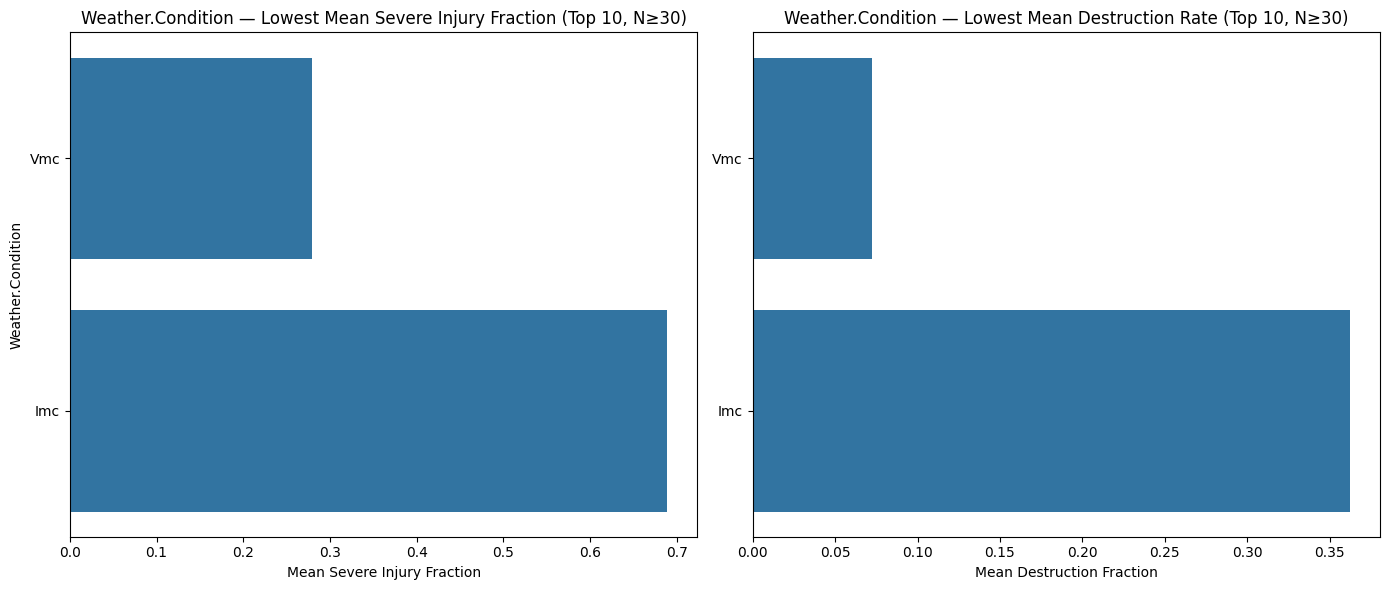

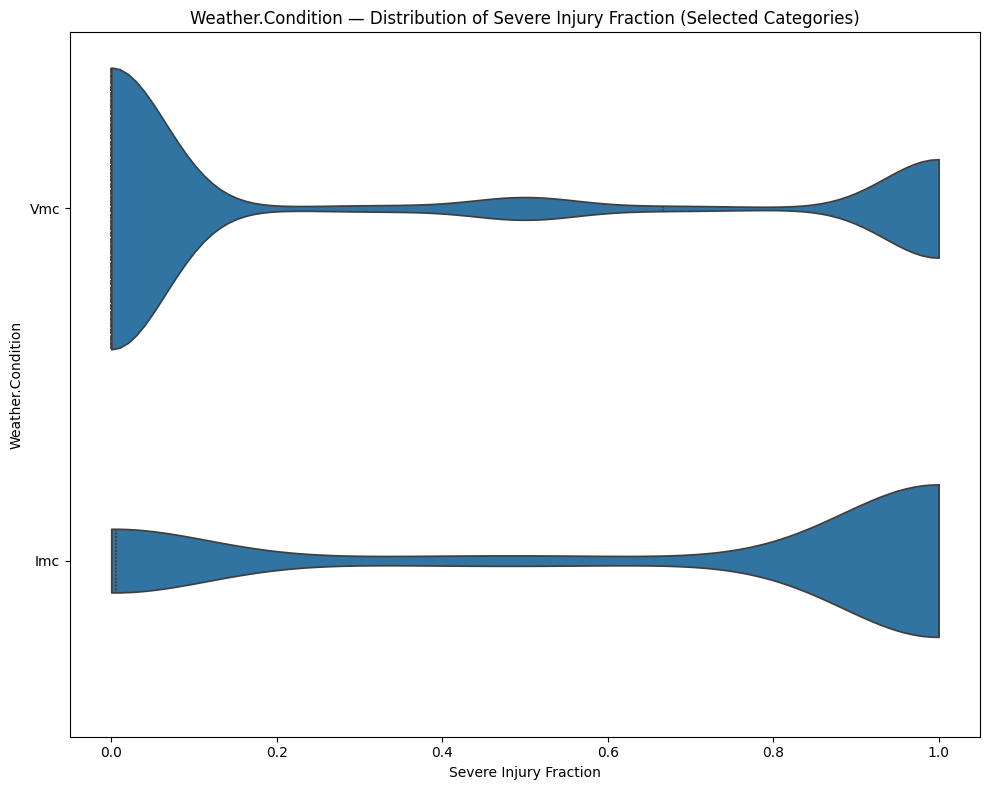

,Engine.Type,N,Mean_Severe_Injury_Fraction,Severe_Injury_Rate,Destruction_Rate
1,Turbo Fan,365,0.145180,0.331507,0.095890
0,Reciprocating,12737,0.303736,0.294261,0.078982
2,Turbo Jet,45,0.317179,0.466667,0.244444
3,Turbo Prop,877,0.367443,0.378563,0.192702


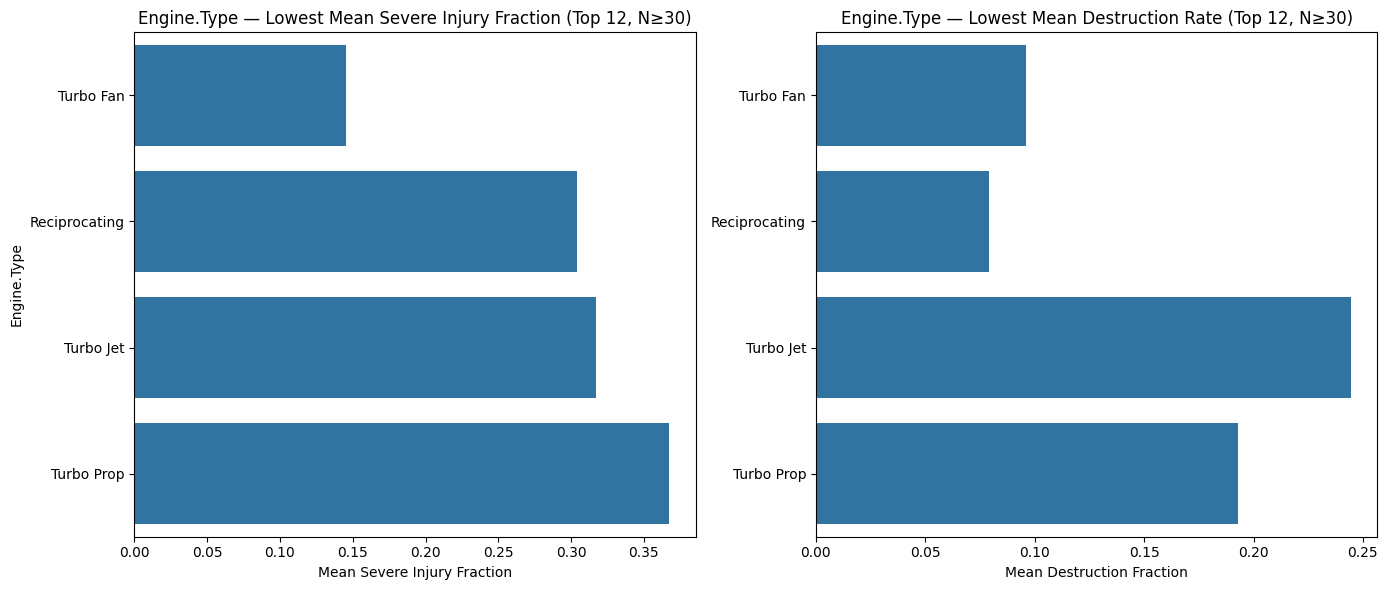

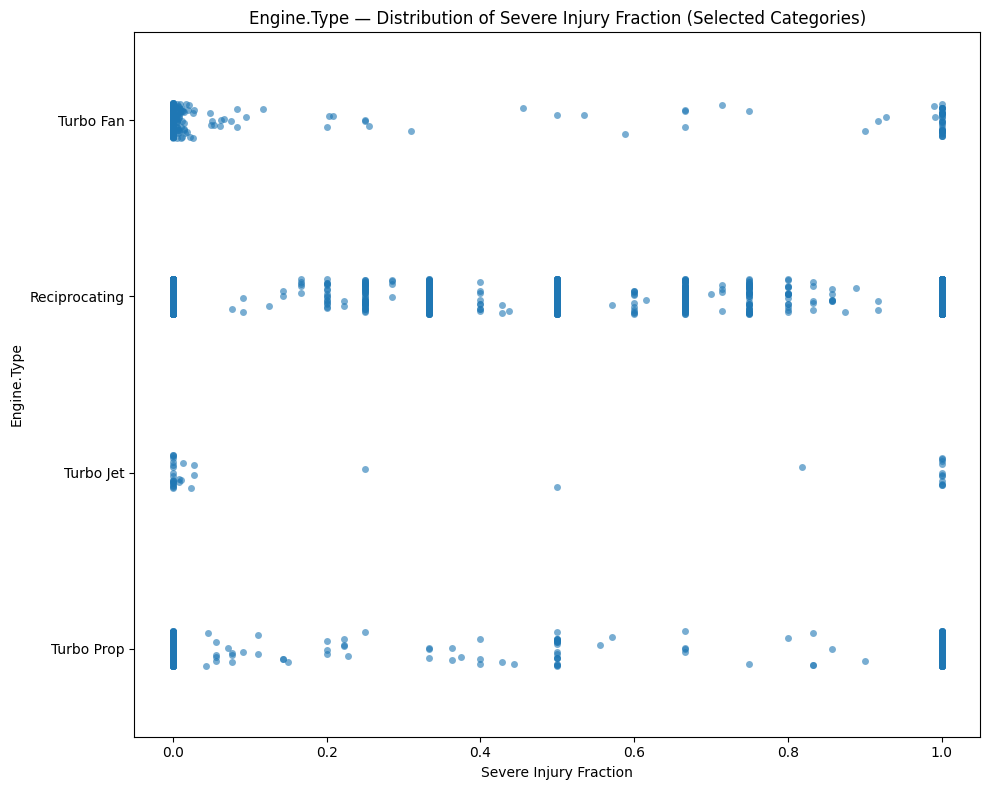

In [17]:
# Analyze two factors: Weather Condition and Phase of Flight
import seaborn as sns
import matplotlib.pyplot as plt

def analyze_factor(df, factor, min_n=30, top_n=10, dist='violin'):
    sub = df.copy()
    sub = sub[sub[factor].notna()]
    agg = (
        sub.groupby(factor)
        .agg(
            N=('Severe.Injury.Flag', 'size'),
            Mean_Severe_Injury_Fraction=('Severe.Injury.Rate', 'mean'),
            Severe_Injury_Rate=('Severe.Injury.Flag', 'mean'),
            Destruction_Rate=('Total.Destruction.Flag', 'mean'),
        )
        .reset_index()
    )
    agg = agg[agg['N'] >= min_n].sort_values('Mean_Severe_Injury_Fraction')
    display(agg)

    order = agg[factor].head(top_n).tolist()

    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=False)
    sns.barplot(
        data=agg.head(top_n),
        x='Mean_Severe_Injury_Fraction',
        y=factor,
        order=order,
        ax=axes[0]
    )
    axes[0].set_title(f'{factor} — Lowest Mean Severe Injury Fraction (Top {top_n}, N≥{min_n})')
    axes[0].set_xlabel('Mean Severe Injury Fraction')
    axes[0].set_ylabel(factor)

    sns.barplot(
        data=agg.head(top_n),
        x='Destruction_Rate',
        y=factor,
        order=order,
        ax=axes[1]
    )
    axes[1].set_title(f'{factor} — Lowest Mean Destruction Rate (Top {top_n}, N≥{min_n})')
    axes[1].set_xlabel('Mean Destruction Fraction')
    axes[1].set_ylabel('')

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 8))
    if dist == 'violin':
        sns.violinplot(
            data=sub[sub[factor].isin(order)],
            x='Severe.Injury.Rate',
            y=factor,
            order=order,
            inner='quartile',
            cut=0
        )
    else:
        sns.stripplot(
            data=sub[sub[factor].isin(order)],
            x='Severe.Injury.Rate',
            y=factor,
            order=order,
            jitter=True,
            alpha=0.6
        )
    plt.title(f'{factor} — Distribution of Severe Injury Fraction (Selected Categories)')
    plt.xlabel('Severe Injury Fraction')
    plt.ylabel(factor)
    plt.tight_layout()
    plt.show()

    return agg

# Weather Condition
weather_summary = analyze_factor(df, factor='Weather.Condition', min_n=30, top_n=10, dist='violin')

# Phase of Flight
engine_summary = analyze_factor(df, factor='Engine.Type', min_n=30, top_n=12, dist='strip')

##### Summary

##### Weather (VMC vs IMC)

- Accidents in IMC have higher mean severe-injury fractions and higher destruction rates than VMC.

- Distributions show a heavier right tail in IMC - more high-severity events.

##### Engine Type

- Turbofan aircraft show the lowest mean severe-injury and destruction rates.

- Turbojet and turboprop show higher means and wider right tails; reciprocating is intermediate.